# **Notes**

1. After training the convolutional autoencoder, the weights will be used for all the combinations of % available Fashion-MNIST-1 training data and initialisation strategies to train CNN.
2. Convolutional autoencoder can be treated as a pre-trained model to get pre-trained weights based on a large amount of unlabeled data.
3. CNN with % available Fashion-MNIST-1 training data represents how limited our actual training data are. (Eg. 5% means only 5% of Fashion-MNIST-1 training data are labeled which can be used to train our CNN predictive model).

# **Settings**

In [270]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [273]:
# Import necessary packages
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler # Needed to construct the validation set
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sb
import copy
torch.manual_seed(42) # Set arbitrary seed
np.random.seed(3) # Set arbitrary seed

In [533]:
# Define the hyperparameters for convolutional autoencoder
no_epochs = 30
lr = 0.001
batch_size = 50 # Set the batch size, which is needed to prepare the data

# Define the hyperparameters for CNN
cnn_no_epochs = 20
cnn_lr = 0.001

# Change these two hyperparameters for different scenarios!
percentage = 1.0 # % of MNIST-1 trainset used to train CNN
init_strategies = "Pre-trained" # "Random","Pre-trained"

path = '/content/gdrive/MyDrive/MSc DSML//UCL/Main/COMP0090 CW + Lab/Assignment 3/Q4/v1.0/{}_{}'.format(str(percentage),init_strategies)
print(path)
os.chdir(path)

/content/gdrive/MyDrive/MSc DSML//UCL/Main/COMP0090 CW + Lab/Assignment 3/Q4/v1.0/1.0_Pre-trained


In [274]:
def set_device():
  if torch.cuda.is_available():
      device = 'cuda:0'
  else:
      device = 'cpu'
  return device

In [275]:
def create_directory():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [276]:
# Specific GPU has to be set for pytorch to work on GPU
device = set_device()
print(device)

cuda:0


In [277]:
create_directory()

# **Part I: Convolutional Autoencoder**

In [278]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Transform images to tensors and normalise

In [279]:
# Download the data (comes as train and test sets)
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [280]:
def split_data(trainset,testset,batch_size,targets):

  torch.manual_seed(42) # Set arbitrary seed
  np.random.seed(3) # Set arbitrary seed

  temp = copy.deepcopy(trainset)
  validset = copy.deepcopy(trainset)

  # Select a subset of classes from the train and test sets to create Fashion-MNIST-1 and Fashion-MNIST-2
  idx = (trainset.targets==targets[0]) | (trainset.targets==targets[1]) | (trainset.targets==targets[2]) | (trainset.targets==targets[3]) | (trainset.targets==targets[4])
  temp.targets = trainset.targets[idx]
  temp.data = trainset.data[idx]

  idx = (testset.targets==targets[0]) | (testset.targets==targets[1]) | (testset.targets==targets[2]) | (testset.targets==targets[3]) | (testset.targets==targets[4])
  testset.targets = testset.targets[idx]
  testset.data = testset.data[idx]

  # Prepare the validation set from the train set (24k or 4/5ths images for train and 6k or 1/5th images for validation)
  indices = list(range(len(temp)))
  np.random.shuffle(indices)
  slice3 = int(len(temp)//5*4)

  trainset.targets = temp.targets[indices[:slice3]]
  trainset.data = temp.data[indices[:slice3]]

  validset.targets = temp.targets[indices[slice3:]]
  validset.data = temp.data[indices[slice3:]]

  return trainset,validset,testset

In [281]:
# Deep copies needed since pytorch dataloader is a pointer
trainset_copy_1 = copy.deepcopy(trainset)
testset_copy_1 = copy.deepcopy(testset)
trainset_copy_2 = copy.deepcopy(trainset)
testset_copy_2 = copy.deepcopy(testset)

trainset_1,validset_1,testset_1 = split_data(trainset_copy_1,testset_copy_1,batch_size,[0,1,4,5,8]) # Fashion-MNIST-1
trainset_2,validset_2,testset_2 = split_data(trainset_copy_2,testset_copy_2,batch_size,[2,3,6,7,9]) # Fashion-MNIST-2

In [282]:
# # Train your model to convergence on the combined training, validation, and test set of Fashion-MNIST-2 and training set of Fashion-MNIST-1

# temp = copy.deepcopy(trainset_1)

# indices = list(range(len(temp)))
# slicer = round(len(temp)*percentage)

# temp.targets = temp.targets[indices[:slicer]]
# temp.data = temp.data[indices[:slicer]]

# CA_training_set = trainset_2 + validset_2 + testset_2 + temp
# CA_trainloader = torch.utils.data.DataLoader(CA_training_set, batch_size=batch_size)

In [283]:
# Train your model to convergence on the combined training, validation, and test set of Fashion-MNIST-2 and training set of Fashion-MNIST-1

CA_training_set = trainset_2 + validset_2 + testset_2 + trainset_1
CA_trainloader = torch.utils.data.DataLoader(CA_training_set, batch_size=batch_size)

In [284]:
# Check datasizes
print(len(trainset))
print(len(testset))
print(len(trainset_1))
print(len(validset_1))
print(len(testset_1))
print(len(trainset_2))
print(len(validset_2))
print(len(testset_2))
print(len(CA_trainloader))
print("{}% of Fashion-MNIST-1 training set is used to train convolutional autoencoder.".format(percentage*100))

60000
10000
24000
6000
5000
24000
6000
5000
1180
5.0% of Fashion-MNIST-1 training set is used to train convolutional autoencoder.


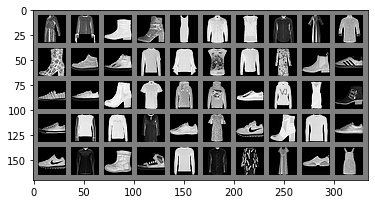

In [285]:
# Load a batch of training images for visualising
data_iterator = iter(CA_trainloader)
images, labels = data_iterator.next()
# images.shape # torch.Size([50, 1, 28, 28])

# Create function for visualisation
def show_image(img):
    img = img * 0.5 + 0.5 # This is to reverse the normalisation done earlier
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
show_image(torchvision.utils.make_grid(images,10,5))
plt.show()

In [286]:
def save_final_image(img, name):
    img = img.view(img.size(0), 1, 28, 28) # save the images for later reference
    save_image(img, name)

In [287]:
# Define class that constructs the Convolutional Autoencoder
class Convolutional_Autoencoder(nn.Module):
    # Convolutional layers
    def __init__(self):
        
        super(Convolutional_Autoencoder, self).__init__()

        # Encoder layers
        self.encode1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.encode2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encode3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.encode4 = nn.Conv2d(32, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.decode1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.decode2 = nn.ConvTranspose2d(8, 32, kernel_size=3, stride=2)
        self.decode3 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.decode4 = nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2)
        self.out = nn.Conv2d(128, 1, kernel_size=3, padding=1)

        # Metrics
        self.losses = []
        self.epoch_track = []
    
    # Forward pass    
    def forward(self, x):

        # Encoder layers 
        x = F.leaky_relu(self.encode1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.encode2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.encode3(x))
        x = self.pool(x)
        x = F.leaky_relu(self.encode4(x))
        x = self.pool(x)

        # Decoder layers
        x = F.leaky_relu(self.decode1(x))
        x = F.leaky_relu(self.decode2(x))
        x = F.leaky_relu(self.decode3(x))
        x = F.leaky_relu(self.decode4(x))
        x = torch.sigmoid(self.out(x))

        return x

    # Training
    def train_net(self, dataset, no_epochs, lr):

        with open('convolutional_autoencoder_training_log.txt', 'w+') as file:
      
          loss_func = nn.MSELoss() # Define MSE loss
          optimizer = optim.Adam(CA.parameters(), lr = lr)

          for epoch in range(no_epochs):

            current_epoch = epoch + 1
            self.epoch_track.append(current_epoch)

            current_loss = 0.0

            for batch_index, training_batch in enumerate(dataset, 0):
            
              inputs, _ = training_batch
              inputs = Variable(inputs)
              inputs = np.clip(inputs, 0., 1.) # Clip to make the values fall between 0 and 1 [VERY IMPORTANT STEP!, either blank img will be generated]
              inputs = inputs.to(device)
              optimizer.zero_grad()
              outputs = self.forward(inputs)
              
              # Calculate loss and optimise
              loss = loss_func(outputs, inputs)
              loss.backward()
              optimizer.step()

              current_loss += loss.item()

            print('[Epoch: %d] loss: %.3f' % (epoch + 1, current_loss / len(dataset)))
            file.write('[Epoch: %d] loss: %.3f\n' % (epoch + 1, current_loss / len(dataset)))
            self.losses.append(current_loss / len(dataset))

            save_final_image(inputs.data, name='./Saved_Images/raw{}.png'.format(epoch))
            save_final_image(outputs.data, name='./Saved_Images/autoencoded{}.png'.format(epoch))

          print('End of training')
          file.write('End of training')

        return self.losses

In [288]:
# Create the Convolutional Autoencoder
CA = Convolutional_Autoencoder()
CA.to(device)

# Train the Convolutional Autoencoder
train_loss = CA.train_net(CA_trainloader, no_epochs, lr)

[Epoch: 1] loss: 0.031
[Epoch: 2] loss: 0.021
[Epoch: 3] loss: 0.019
[Epoch: 4] loss: 0.019
[Epoch: 5] loss: 0.018
[Epoch: 6] loss: 0.018
[Epoch: 7] loss: 0.018
[Epoch: 8] loss: 0.017
[Epoch: 9] loss: 0.017
[Epoch: 10] loss: 0.017
[Epoch: 11] loss: 0.017
[Epoch: 12] loss: 0.017
[Epoch: 13] loss: 0.017
[Epoch: 14] loss: 0.017
[Epoch: 15] loss: 0.017
[Epoch: 16] loss: 0.017
[Epoch: 17] loss: 0.016
[Epoch: 18] loss: 0.016
[Epoch: 19] loss: 0.016
[Epoch: 20] loss: 0.016
[Epoch: 21] loss: 0.016
[Epoch: 22] loss: 0.016
[Epoch: 23] loss: 0.016
[Epoch: 24] loss: 0.016
[Epoch: 25] loss: 0.016
[Epoch: 26] loss: 0.016
[Epoch: 27] loss: 0.016
[Epoch: 28] loss: 0.016
[Epoch: 29] loss: 0.016
[Epoch: 30] loss: 0.016
End of training


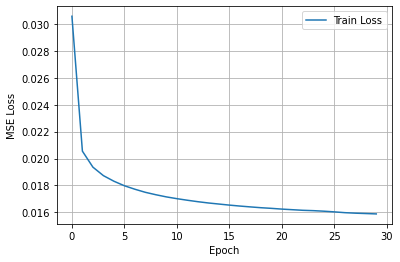

In [289]:
# Loss Plots
x = list(range(len(train_loss)))
plt.plot(x, train_loss, label = "Train Loss") 
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()
plt.savefig("assignment_3_task_4_part_2.jpg")
plt.show()

# **Part II: Convolutional Neural Network**

In [290]:
# Define class that constructs the Convolutional Neural Network
class CNN(nn.Module):
    # Convolutional layers
    def __init__(self):
        
        super(CNN, self).__init__()

        # Encoder layers
        self.encode1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.encode2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encode3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.encode4 = nn.Conv2d(32, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # MLP layers
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

        # self.drop = nn.Dropout2d(0.25)
        self.drop = nn.Dropout2d(0)

        # Metrics
        self.losses = []
        self.accuracies = []

        self.validlosses = []
        self.validaccuracies = []
        self.epoch_track = []
    
    # Forward pass    
    def forward(self, x):

        # Encoder layers 
        x = F.leaky_relu(self.encode1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.encode2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.encode3(x))
        x = self.pool(x)
        x = F.leaky_relu(self.encode4(x))
        x = self.pool(x)

        # MLP layers

        x = x.view(-1, x.size(1)) # The output of the 2nd convolutional layer needs to be flattened to feed into the next layer
        x = F.leaky_relu(self.fc1(x))
        x = self.drop(x) 
        x = F.leaky_relu(self.fc2(x))
        x = self.drop(x) 
        x = F.log_softmax(self.fc3(x))

        return x

    # Training and validation
    def train_valid_net(self, trainset, validset, no_epochs, lr):

        with open('CNN_training_validation_log.txt', 'w+') as file:

          loss_func = nn.CrossEntropyLoss() # Define Cross-Entropy loss
          optimizer = optim.Adam(cnn.parameters(), lr = lr)

          best_valid_loss = 100
          best_valid_epoch = -1

          for epoch in range(no_epochs):

            current_epoch = epoch + 1
            self.epoch_track.append(current_epoch)

            current_loss = 0.0
            current_accuracy = 0.0
            correct_pred = 0
            total_pred = 0
            
            valid_current_loss = 0.0
            valid_current_accuracy = 0.0
            valid_correct_pred = 0
            valid_total_pred = 0

            # Training
            for batch_index, training_batch in enumerate(trainset, 0):
            
              inputs, labels = training_batch
              inputs, labels = Variable(inputs), Variable(labels)
              inputs, labels = inputs.to(device), labels.to(device)
              optimizer.zero_grad()
              outputs = self.forward(inputs)
              
              # Calculate loss and optimise
              loss = loss_func(outputs, labels)
              loss.backward()
              optimizer.step()
              current_loss += loss.item()

              # Calculate accuracy
              _, pred_labels = torch.max(outputs.data, 1)
              correct_pred += (pred_labels == labels).sum().item()
              total_pred += pred_labels.size(0)

            print('[Epoch: %d] Training Loss: %.3f' % (epoch + 1, current_loss / len(trainset)))
            file.write('[Epoch: %d] Training Loss: %.3f\n' % (epoch + 1, current_loss / len(trainset)))
            self.losses.append(current_loss / len(trainset))
            print('[Epoch: %d] Training Accuracy: %.3f' % (epoch + 1, (100 * correct_pred)/total_pred))
            file.write('[Epoch: %d] Training Accuracy: %.3f\n' % (epoch + 1, (100 * correct_pred)/total_pred))
            self.accuracies.append((100 * correct_pred)/total_pred)

            # Validation
            for batch_index, valid_batch in enumerate(validset, 0):
            
              inputs, labels = valid_batch
              inputs, labels = Variable(inputs), Variable(labels)
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = self.forward(inputs)
              
              # Calculate loss
              loss = loss_func(outputs, labels)
              valid_current_loss += loss.item()

              # Calculate accuracy
              _, pred_labels = torch.max(outputs.data, 1)
              valid_correct_pred += (pred_labels == labels).sum().item()
              valid_total_pred += pred_labels.size(0)

              # print(labels,pred_labels)

            if best_valid_loss > valid_current_loss / len(validset):
              best_valid_loss = valid_current_loss / len(validset)
              best_valid_epoch = current_epoch
              best_model = copy.deepcopy(cnn)
            
            # for param1, param2 in zip(best_model.parameters(), self.parameters()):
            #   print((param1 == param2).all())

            print('[Epoch: %d] Validation Loss: %.3f' % (epoch + 1, valid_current_loss / len(validset)))
            file.write('[Epoch: %d] Validation Loss: %.3f\n' % (epoch + 1, valid_current_loss / len(validset)))
            self.validlosses.append(valid_current_loss / len(validset))
            print('[Epoch: %d] Validation Accuracy: %.3f' % (epoch + 1, (100 * valid_correct_pred)/valid_total_pred))
            file.write('[Epoch: %d] Validation Accuracy: %.3f\n' % (epoch + 1, (100 * valid_correct_pred)/valid_total_pred))
            self.validaccuracies.append((100 * valid_correct_pred)/valid_total_pred)

          print('End of training, best epoch is {}'.format(best_valid_epoch))
          file.write('End of training, best epoch is {}'.format(best_valid_epoch))
              
        return self.losses, self.accuracies, self.validlosses, self.validaccuracies, best_model

In [291]:
# Evaluation
def evaluate_net(best_model, dataset, no_epochs, lr):

    # print(best_model.state_dict()["encode1.weight"])

    loss_func = nn.CrossEntropyLoss() # Define Cross-Entropy loss

    current_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for batch_index, batch in enumerate(dataset, 0):
    
      inputs, labels = batch
      inputs, labels = Variable(inputs), Variable(labels)
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = best_model.forward(inputs)

      # Calculate loss
      loss = loss_func(outputs, labels)
      current_loss += loss.item()
      
      # Calculate accuracy
      _, pred_labels = torch.max(outputs.data, 1)
      correct_pred += (pred_labels == labels).sum().item()
      total_pred += pred_labels.size(0)

    return current_loss/len(dataset), (100*correct_pred)/total_pred

# **To run**

In [534]:
temp = copy.deepcopy(trainset_1)
indices = list(range(len(temp)))
slicer = round(len(temp)*percentage)
temp.targets = temp.targets[indices[:slicer]]
temp.data = temp.data[indices[:slicer]]

cnn_trainloader = torch.utils.data.DataLoader(temp, batch_size=batch_size)
cnn_validloader = torch.utils.data.DataLoader(validset_1, batch_size=batch_size)
cnn_testloader = torch.utils.data.DataLoader(testset_1, batch_size=batch_size, shuffle=True)

In [535]:
# Create the CNN
cnn = CNN()
cnn.to(device)

if init_strategies == "Pre-trained": # Use pre-trained weights of the encoder part from convolutional autoencoder

  model_dict = CA.state_dict()
  cnn.encode1.weight.data.copy_(model_dict["encode1.weight"])
  cnn.encode1.bias.data.copy_(model_dict["encode1.bias"])
  cnn.encode2.weight.data.copy_(model_dict["encode2.weight"])
  cnn.encode2.bias.data.copy_(model_dict["encode2.bias"])
  cnn.encode3.weight.data.copy_(model_dict["encode3.weight"])
  cnn.encode3.bias.data.copy_(model_dict["encode3.bias"])
  cnn.encode4.weight.data.copy_(model_dict["encode4.weight"])
  cnn.encode4.bias.data.copy_(model_dict["encode4.bias"])

# Train the CNN
cnn_train_loss, cnn_train_accuracies, cnn_valid_loss, cnn_valid_accuracies, best_model = cnn.train_valid_net(cnn_trainloader, cnn_validloader, cnn_no_epochs, cnn_lr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch: 1] Training Loss: 0.287
[Epoch: 1] Training Accuracy: 93.021
[Epoch: 1] Validation Loss: 0.101
[Epoch: 1] Validation Accuracy: 96.867
[Epoch: 2] Training Loss: 0.079
[Epoch: 2] Training Accuracy: 97.642
[Epoch: 2] Validation Loss: 0.067
[Epoch: 2] Validation Accuracy: 98.050
[Epoch: 3] Training Loss: 0.061
[Epoch: 3] Training Accuracy: 98.133
[Epoch: 3] Validation Loss: 0.078
[Epoch: 3] Validation Accuracy: 97.767
[Epoch: 4] Training Loss: 0.050
[Epoch: 4] Training Accuracy: 98.517
[Epoch: 4] Validation Loss: 0.077
[Epoch: 4] Validation Accuracy: 97.800
[Epoch: 5] Training Loss: 0.040
[Epoch: 5] Training Accuracy: 98.754
[Epoch: 5] Validation Loss: 0.063
[Epoch: 5] Validation Accuracy: 98.450
[Epoch: 6] Training Loss: 0.033
[Epoch: 6] Training Accuracy: 98.975
[Epoch: 6] Validation Loss: 0.057
[Epoch: 6] Validation Accuracy: 98.417
[Epoch: 7] Training Loss: 0.032
[Epoch: 7] Training Accuracy: 99.029
[Epoch: 7] Validation Loss: 0.060
[Epoch: 7] Validation Accuracy: 98.500
[Epoch

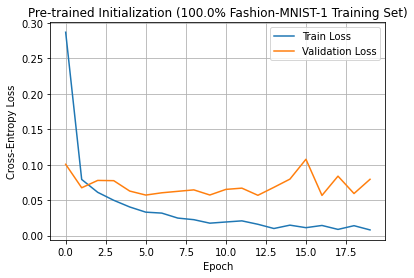

In [536]:
# Loss Plots
x = list(range(len(cnn_train_loss)))
plt.plot(x, cnn_train_loss, label = "Train Loss") 
plt.plot(x, cnn_valid_loss, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title("{} Initialization ({}% Fashion-MNIST-1 Training Set)".format(init_strategies, percentage*100))
plt.grid()
plt.legend()
plt.savefig("assignment_3_task_4_part_3_loss.jpg")
plt.show()

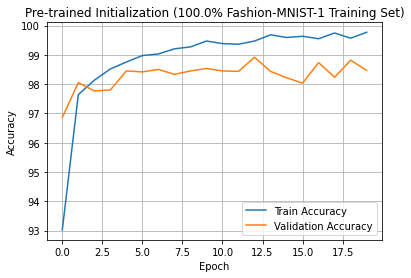

In [537]:
# Accuracy Plots
x = list(range(len(cnn_train_accuracies)))
plt.plot(x, cnn_train_accuracies, label = "Train Accuracy") 
plt.plot(x, cnn_valid_accuracies, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("{} Initialization ({}% Fashion-MNIST-1 Training Set)".format(init_strategies, percentage*100))
plt.grid()
plt.legend()
plt.savefig("assignment_3_task_4_part_3_acc.jpg")
plt.show()    

In [538]:
best_train_loss, best_train_acc = evaluate_net(best_model, cnn_trainloader, cnn_no_epochs, cnn_lr)
best_valid_loss, best_valid_acc = evaluate_net(best_model, cnn_validloader, cnn_no_epochs, cnn_lr)
best_test_loss, best_test_acc = evaluate_net(best_model, cnn_testloader, cnn_no_epochs, cnn_lr)

with open('best_model_training_validation_test_acc_log.txt', 'w+') as file:

  print("Weights Based On {} Initialization ({}% Fashion-MNIST-1 Training Set)".format(init_strategies, percentage*100))
  file.write("Weights Based On {} Initialization ({}% Fashion-MNIST-1 Training Set)\n".format(init_strategies, percentage*100))
  print("Final Training Accuracy: {}".format(best_train_acc))
  file.write("Final Training Accuracy: {}\n".format(best_train_acc))
  print("Final Validation Accuracy: {}".format(best_valid_acc))
  file.write("Final Validation Accuracy: {}\n".format(best_valid_acc))
  print("Final Test Accuracy: {}".format(best_test_acc))
  file.write("Final Test Accuracy: {}".format(best_test_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Weights Based On Pre-trained Initialization (100.0% Fashion-MNIST-1 Training Set)
Final Training Accuracy: 99.75416666666666
Final Validation Accuracy: 98.73333333333333
Final Test Accuracy: 98.76
